In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
import os
import sys

from trig_fund import *
from dambreak import dambreak_T_K
from syrup_prop import *

# filter warnings regularly ecountered in the model
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in power")
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in less")
warnings.filterwarnings("ignore", message="overflow encountered in true_divide")

Generalized flow for Herschel-Bulkley fluid on a slope following derivation from Liu & Mei (1989):

$ \begin{align} (\rho h)_t &= \frac{\partial}{\partial x} \left[ \rho \left( \frac{\rho g}{K} \right)^{1/n} \frac{n \left| \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right) \right) \right] \\ Y &= h - \frac{\tau_y}{\rho g |\sin{\theta} - \frac{\partial}{\partial x} \left( h \cos{\theta} \right)|} \end{align}$


Conservation of energy:

$ \begin{align} T_t &= - \frac{\partial}{\partial x} \left( qT \right) + \frac{\partial}{\partial x} \left( \frac{k_T}{\rho c_p} T_x \right) - \frac{\sqrt{\left( h_x \right)^2 + 1}}{\rho c_p h} \left[ e \sigma \left( T^4 - T_{atm}^4 \right) + h_{atm}\left( T - T_{atm} \right) \right] + \sum_{i=1}^{N} \frac{\rho_i L_i}{\rho c_p} \Gamma_i \\ q &= Q/\rho h  \end{align}$

Phase averaged quantities:

$ \begin{align} \bar{\rho} &= \sum_{i=1}^{N} \phi_i \rho_i \\
    \bar{c}_p &= \left(\sum_{i=1}^{N} \phi_i \rho_i {c_p}_i \right) / \bar{\rho} \\
    \bar{k}_T &= \left(\sum_{i=1}^{N} \phi_i \rho_i {k_T}_i \right) / \bar{\rho} \end{align}$

In [ ]:
T_fit = np.linspace(23.5, 46, 50)
Visc_fit = Visc(T_fit)
T_dat = [23.5, 26, 26.5, 30, 36, 40, 46]
T_err = [0.5, 1,1 , 3, 3, 3, 3]
Visc_dat = [6.588, 5.979, 5.592, 3.606, 2.204, 2.255, 1.303]
Visc_stdev = [0.032, 0.0064, 0.0064, 0.006, 0.0269, 0.112, 0.0386]

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(T_fit,Visc_fit,'k-')
#ax.errorbar(T_dat, Visc_dat, xerr=T_err, yerr=Visc_stdev,
           #linestyle='none', fmt='ro')
ax.set_xlabel(r'Temperature [$^\circ$C]')
ax.set_ylabel('Viscosity [Pa s]')
ax.set_title('Temperature dependence of corn syrup viscosity')

In [ ]:
T_fit = np.linspace(23.5, 46, 50)
Density_fit = Density(T_fit)

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(T_fit,Density_fit,'k-')
ax.set_xlabel(r'Temperature [$^\circ$C]')
ax.set_ylabel('Density [$Kg/m^3$]')
ax.set_title('Temperature dependence of corn syrup viscosity')

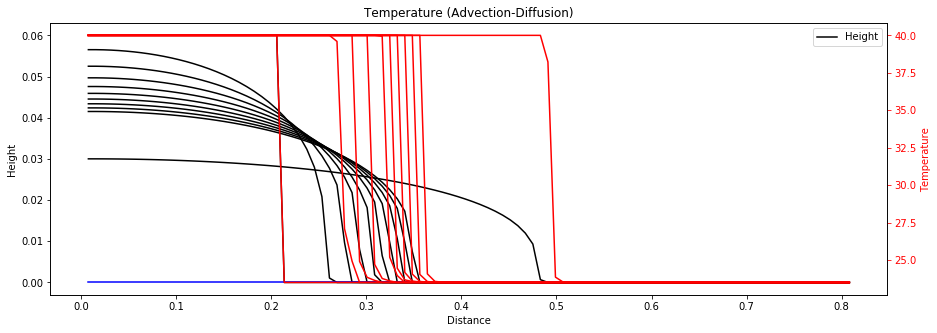

In [5]:
H = 0.06 # reservoir height in m
L = 0.20  # reservoir length in m

# Discretize domain 
m = 100
x = np.linspace(0, 4*L, m+2)
dx = x[1] - x[0]

ts = 1 # time in s
i = 50000

theta = 0*np.ones(m+2)

# Dimensional
g = 10   # gravitational acceleration m/s^2
k_T = 0.353 # thermal conductivity
cp = 2278   # specific heat capacity

n = np.ones((i+2,m+2)) # power law exponent
K = 2*np.ones((i+2,m+2))  # consistency in Pas
rho = 1395*np.ones((i+2,m+2)) # density in kg/m^3
tauy = 0*np.ones((i+2,m+2)) # yield stress in Pa

T_atm = 23.5 # Air temperature in deg C
h_atm = 10 # Air convective heat transfer coefficient
e = 0.95

# Initial condition
h0 = np.zeros(m+2)
h0[x<=L] = H
T0 = T_atm*np.ones(m+2)
T0[x<=L] = 40
T_lft = 40*np.ones(i+2)

theta = np.zeros_like(x)
x_trans = np.cumsum(cosd(theta)*dx)
z0 = np.cumsum(sind(-theta)*dx)
z0 -= np.min(z0)

h, t, T = dambreak_T_K(x, h0, T0, T_lft, theta, tauy, n, g, k_T, cp, T_atm, h_atm, e, ts, i)

fig,ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()
for k in 1000*np.arange(10):
    ax.plot(x_trans,h[k,:].transpose()*cosd(theta) + z0,'k-');
    ax2.plot(x_trans,T[k,:].transpose()*cosd(theta) + z0,'r-');
ax.plot(x_trans,h[-1,:].transpose()*cosd(theta) + z0,'k-',label='Height');
ax2.plot(x_trans,T[-1,:].transpose()*cosd(theta) + z0,'r-',label='Temperature');
ax.plot(x_trans,z0,'b-');
ax.set_xlabel('Distance')
ax.set_ylabel('Height')
ax2.set_ylabel('Temperature')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax.set_title('Temperature (Advection-Diffusion)');
ax.legend();